# QA solid solutions

- [Build the structures](#structures)
- [Build the test/train set](#manual_confcount)
- [Build the QUBO model](#ml_energies)
- [Graphene Exhaustive Search](#graphene_es)
- [Run the anneal](#anneal_binary)
    - [GaAlN](#anneal_binary_gaaln) 
    - [WMo](#anneal_binary_wmo) 
- [Test QUBO classical](#test_QUBO_classical)
- [Experiments](#experiments)

In [2]:
from symmetry_functions import *
from QA_solid_solutions_functions import *

from dwave.embedding.chain_strength import  uniform_torque_compensation

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.vasp import *

from ase.visualize import view

from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import sys

import re
import shutil as sh

from CRYSTALpytools.crystal_io import * 
from CRYSTALpytools.convert import * 

import copy
from sklearn.metrics import mean_squared_error 

import dataframe_image as dfi
#from dscribe.descriptors import CoulombMatrix
from scipy import constants

import matplotlib.pyplot as plt

import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

from dwave.system import EmbeddingComposite, DWaveSampler
import dimod 

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

import seaborn as sns

In [7]:
def get_qubo_probability(mu=0.,temperature=298.15, return_all = False):
    graphene_allN_cry_energy_norm_flat = []
    graphene_multiplicity_all_list_flat = []
    graphene_allN_qubo_energy_norm_flat = []
    graphene_allN_qubo_energy_norm_flat_no_pot = []
    num_N = []

    T = temperature
    for i in range(len(graphene_allN_qubo_energy_list)):
        
        graphene_allN_qubo_energy_norm_flat.extend(np.array(graphene_allN_qubo_energy_list[i])+mu*i)
        
        graphene_allN_qubo_energy_norm_flat_no_pot.extend(np.array(graphene_allN_qubo_energy_list[i]))
        graphene_multiplicity_all_list_flat.extend(graphene_multiplicity_all_list[i])

    Z,pi = get_partition_function(graphene_allN_qubo_energy_norm_flat,
                                  graphene_multiplicity_all_list_flat,return_pi=True,T=temperature)
    
   
    
    graphene_allN_qubo_energy_norm_flat = np.round(np.array(graphene_allN_qubo_energy_norm_flat),6)
    graphene_allN_qubo_energy_norm_flat_no_pot = np.round(np.array(graphene_allN_qubo_energy_norm_flat_no_pot),6)
    
    unique_energies, unique_index, unique_counts = np.unique(graphene_allN_qubo_energy_norm_flat_no_pot,
                                                              return_index=True,return_counts=True)
    
    graphene_allN_qubo_energy_norm_flat_no_pot = np.round(graphene_allN_qubo_energy_norm_flat_no_pot,6)
#     print(graphene_allN_qubo_energy_norm_flat_no_pot)
    unique_energies = np.round(unique_energies,6)
    graphene_multiplicity_all_list_flat = np.array(graphene_multiplicity_all_list_flat)
    probability_unique_energies = []
    mult_unique = []
    for ue in unique_energies:
        ue_index = np.where(graphene_allN_qubo_energy_norm_flat_no_pot == ue)[0]

        probability_unique_energies.append(np.sum(pi[ue_index]))
        mult_unique.append(np.sum(graphene_multiplicity_all_list_flat[ue_index]))
    probability_unique_energies = np.array(probability_unique_energies)
    
    if return_all == True:
    
        return unique_energies, probability_unique_energies, Z, mult_unique, uniq
    else:
        return unique_energies, probability_unique_energies
    
# unique_energies,probability_energy, Z, mult = get_qubo_probability_test(mu=0.,temperature=1000, return_all=True)


# <a id='structures'>Build the structures</a>


# <a id='graphene_structure'>Graphene</a>

In [5]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

#optimised cell
lattice = np.array([[  0.212090484210E+01, -0.122450498151E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.244900996303E+01,  0.000000000000E+00],
  [0.000000000000E+00,  0.000000000000E+00,  0.500000000000E+03]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/config_analysis/graphene_confcount.gui'))

#number of atoms
N_C_g = graphene_50.num_sites

In [6]:
graphene_50

Structure Summary
Lattice
    abc : 12.247491749965072 12.24749175 500.0
 angles : 90.0 90.0 120.00000000009433
 volume : 64952.36175099156
      A : 10.6066389881 -6.123745875 0.0
      B : 0.0 12.24749175 0.0
      C : 0.0 0.0 500.0
    pbc : True True True
PeriodicSite: C (-1.414, 1.467e-16, 0.0) [-0.1333, -0.06667, 0.0]
PeriodicSite: C (-1.414, 2.449, 0.0) [-0.1333, 0.1333, 0.0]
PeriodicSite: C (-1.414, 4.899, 0.0) [-0.1333, 0.3333, 0.0]
PeriodicSite: C (-1.414, -4.899, 0.0) [-0.1333, -0.4667, 0.0]
PeriodicSite: C (-1.414, -2.449, 0.0) [-0.1333, -0.2667, 0.0]
PeriodicSite: C (0.7071, -1.225, 0.0) [0.06667, -0.06667, 0.0]
PeriodicSite: C (0.7071, 1.225, 0.0) [0.06667, 0.1333, 0.0]
PeriodicSite: C (0.7071, 3.674, 0.0) [0.06667, 0.3333, 0.0]
PeriodicSite: C (0.7071, -6.124, 0.0) [0.06667, -0.4667, 0.0]
PeriodicSite: C (0.7071, -3.674, 0.0) [0.06667, -0.2667, 0.0]
PeriodicSite: C (2.828, -2.449, 0.0) [0.2667, -0.06667, 0.0]
PeriodicSite: C (2.828, -2.934e-16, 0.0) [0.2667, 0.1333, 0.0]

# <a id='gaaln'>AlGaN</a>

In [7]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

aln_bulk = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/GaAlN/AlN_bulk.gui'))
aln_108 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/GaAlN/config_analysis/AlN_confcount.gui'))
aln_108_all = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/GaAlN/AlN_108.gui'))

#number of atoms
N_al = aln_108.num_sites


# <a id='wmo'>TaW</a>

In [9]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

mo_64 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/WMo/config_analysis/Mo_confcount.gui')) #THIS IS THE REFERENCE GEOMETRY

#number of atoms
N_mo = mo_64.num_sites

### Save to cif

In [12]:
from pymatgen.io.cif import CifWriter
CifWriter(graphene_50).write_file('data/structures/graphene_50.cif')
CifWriter(aln_108_all).write_file('data/structures/AlN_108.cif')
CifWriter(mo_64).write_file('data/structures/Mo_64.cif')

# <a id='manual_confcount'>Build the test/train set</a>

### Graphene

#### Nitrogen

# CRYSTALpytools issue (in progress)

In [ ]:
#graphene
gui_object = Crystal_gui().read_gui('data/crystal/graphene/config_analysis/graphene_confcount.gui')
atom_indices_graphene = get_all_configurations(gui_object)
active_sites=np.where(np.array(graphene_50.atomic_numbers) == 6)[0]
num_active_sites=len(active_sites)
for n,i in enumerate(range(1,11,1)):
    N_atoms = i
    structures_random = generate_random_structures(graphene_50,atom_indices=atom_indices_graphene,N_atoms=N_atoms,
                                                   new_species=7,N_config=500,
                               DFT_config=20,active_sites=active_sites)
    num_structures = len(structures_random)
    train_folder = 'data/crystal/graphene/train_set/'
    test_folder = 'data/crystal/graphene/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,False],symmetry=True)
        gui_name = 'graphene_%sN_%s.gui'%(N_atoms,m)
    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,False],symmetry=True)
        gui_name = 'graphene_%sN_%s.gui'%(N_atoms,m)
     

### AlN-GaN

In [ ]:
gui_object = Crystal_gui().read_gui('data/crystal/GaAlN/config_analysis/AlN_confcount.gui')
atom_indices_gaaln = get_all_configurations(gui_object)
active_sites=np.where(np.array(aln_108.atomic_numbers) == 13)[0]
num_active_sites=len(active_sites)
for n,i in enumerate(range(1,55,5)):

    N_atoms = i
    structures_random = generate_random_structures(aln_108_all,atom_indices=atom_indices_gaaln,
                                                   N_atoms=N_atoms,new_species=31,N_config=500,
                                                   DFT_config=10,active_sites=active_sites)

    num_structures = len(structures_random)

    train_folder = 'data/crystal/GaAlN/train_set/'
    test_folder = 'data/crystal/GaAlN/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'GaAlN_%s_%s.gui'%(i,m)

    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'GaAlN_%s_%s.gui'%(i,m)


### Ta-W

In [ ]:
#WMo - This is not needed because I used VASP
gui_object = Crystal_gui().read_gui('data/crystal/WMo/config_analysis/Mo_confcount.gui')
atom_indices_wmo = get_all_configurations(gui_object)
active_sites=np.where(np.array(mo_64.atomic_numbers) == 42)[0]
num_active_sites=len(active_sites)

for n,i in enumerate(np.arange(1,65,5)):

    N_atoms = i
    structures_random = generate_random_structures(mo_64,atom_indices=atom_indices_wmo,N_atoms=N_atoms,new_species=74,N_config=500,
                               DFT_config=10,active_sites=active_sites)
    num_structures = len(structures_random)

    train_folder = 'data/crystal/WMo/train_set/'
    test_folder = 'data/crystal/WMo/test_set/'
    for m,structure in enumerate(structures_random[0:int(np.ceil(num_structures/2))]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'WMo_%s_%s.gui'%(N_atoms,m)

    for m,structure in enumerate(structures_random[int(np.ceil(num_structures/2)):]):
        gui_object = cry_pmg2gui(structure,pbc=[True,True,True],symmetry=False)
        gui_name = 'WMo_%s_%s.gui'%(N_atoms,m)


# <a id='ml_energies'>Build the QUBO model</a>

### Graphene

In [14]:
#TMP
E_g = Crystal_output().read_cry_output('data/crystal/graphene/graphene_pob_TZVP.out').get_final_energy()
E_graphene = E_g*25

In [15]:
# atomic
E_C = Crystal_output().read_cry_output('data/crystal/reference_state/C_graphene_BSSE.out').get_final_energy()
E_N = Crystal_output().read_cry_output('data/crystal/reference_state/N_graphene_BSSE.out').get_final_energy()

N_sites = 50

In [16]:
# standard state
E_N = Crystal_output().read_cry_output('data/crystal/graphene/N2.out').get_final_energy()/2
E_C = Crystal_output().read_cry_output('data/crystal/graphene/graphene_pob_TZVP.out').get_final_energy()/2

N_sites = 50

In [18]:
import os
N_atom = 7

N_sites = graphene_50.num_sites

gui_object = Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui')

train_folder = 'data/crystal/graphene/train_set/'

structures_train = []
energies_train = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        file_name = file[:-4]
        
        crystal_gui = Crystal_gui().read_gui(train_folder+file_name+'.gui')
        structure = cry_gui2pmg(crystal_gui)
        structures_train.append(structure)
        
        N_N = np.sum(np.array(structure.atomic_numbers) == 7)
        N_C = N_sites - N_N
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        energy_norm = (energy - (E_C*N_C) - (E_N*N_N))/50 - (E_graphene - (E_C*50))/50
        energies_train.append(energy_norm)

test_folder = 'data/crystal/graphene/test_set/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        file_name = file[:-4]
        
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')
        structure = cry_gui2pmg(crystal_gui)

        structures_test.append(structure)
        
        N_N = np.sum(np.array(structure.atomic_numbers) == 7)
        N_C = N_sites - N_N
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        energy_norm = (energy - (E_C*N_C) - (E_N*N_N))/50 - (E_graphene - (E_C*50))/50
        energies_test.append(energy_norm)        



In [20]:
gui_object = Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui')
structure = cry_gui2pmg(gui_object)

atom_indices_graphene = get_all_configurations(gui_object)

num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_graphene,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_graphene,N_atom)

Q_graphene_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=2)

y_pred = get_qubo_energies(Q_graphene_ml,X_test)
test_qubo_energies(y_pred,y_test)

R2:  0.9925641360811356


9.667185543613189e-05

### AlN-GaN

In [22]:
E_al = Crystal_output().read_cry_output('data/crystal/GaAlN/Al_BSSE_AlN_108.out').get_final_energy()
E_ga = Crystal_output().read_cry_output('data/crystal/GaAlN/Ga_BSSE_AlN_108.out').get_final_energy()
E_aln = Crystal_output().read_cry_output('data/crystal/GaAlN/AlN_bulk.out').get_final_energy()  * 27
N_sites = 108

In [23]:
gui_object = Crystal_gui().read_gui('data/crystal/GaAlN/config_analysis/AlN_confcount.gui')
pmg_gui_object = copy.deepcopy(aln_108_all)
pmg_gui_object.translate_sites(np.arange(108),[1,1,1])
original_frac_cart = np.round(pmg_gui_object.frac_coords,8)

In [ ]:
#FROM GUI
import os
N_atom = 31

gui_object = Crystal_gui().read_gui('data/crystal/GaAlN/AlN_108.gui')


train_folder_og = 'data/crystal/GaAlN/train_set/'

structures_train = []
energies_train = []
for file in os.listdir(train_folder):
    if file.endswith('.out'):
        ordering = []
        #print('train',file)
        file_name = file[:-4]
        #print(train_folder_cif+file_name+'.cif')
        crystal_gui = Crystal_gui().read_gui(train_folder_og+file_name+'.gui')

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])

        structures_train.append(structure)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(train_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_train.append(energy_norm)

test_folder = 'data/crystal/GaAlN/test_set/'

structures_test = []
energies_test = []
for file in os.listdir(test_folder):
    if file.endswith('.out'):
        ordering = []
    
        file_name = file[:-4]
        crystal_gui = Crystal_gui().read_gui(test_folder+file_name+'.gui')

        structure = cry_gui2pmg(crystal_gui)

        structure.remove_species([7])

        structures_test.append(structure)
        
        N_ga = np.sum(np.array(structure.atomic_numbers) == 31)
        N_al = np.sum(np.array(structure.atomic_numbers) == 13)
        
        crystal_output = Crystal_output().read_cry_output(test_folder+file)
        energy = crystal_output.get_final_energy()
        #print(file,energy)
        energy_norm = (energy - (E_al*N_al) - (E_ga*N_ga))/54 - (E_aln - (E_al*54))/54
        energies_test.append(energy_norm)      



In [ ]:
gui_object = Crystal_gui().read_gui('data/crystal/GaAlN/AlN_108_Al_only.gui')
structure = cry_gui2pmg(gui_object)
N_atom = 31

# atom_indices_gaaln = get_all_configurations(gui_object)
atom_indices_gaaln = np.genfromtxt('data/crystal/GaAlN/atom_indices_gaaln',delimiter=',',dtype='int')
num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_gaaln,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_gaaln,N_atom)

Q_gaaln_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=4)

y_pred = get_qubo_energies(Q_gaaln_ml,X_test)
test_qubo_energies(y_pred,y_test)

## TaW

In [40]:
E_W = (Outcar('data/vasp/Bulk/W/OUTCAR').final_energy)/64
E_Ta = (Outcar('data/vasp/Bulk/Ta/OUTCAR').final_energy)/64

In [41]:
import os
N_atom = 73

gui_object = Crystal_gui().read_gui('data/crystal/WMo/config_analysis/Mo_confcount.gui')

train_folder = 'data/vasp/TaW/train_set/'

structures_train = []
energies_train = []
energies_train_not_norm = []
all_folders = [folder for folder in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, folder))]
for folder in all_folders:

    crystal_gui = Crystal_gui().read_gui(train_folder+folder+'.gui')

    structure = cry_gui2pmg(crystal_gui)

    structures_train.append(structure)

    N_W = np.sum(np.array(structure.atomic_numbers) == 74)
    N_Ta = np.sum(np.array(structure.atomic_numbers) == 73)

    energy = Outcar(train_folder+folder+'/OUTCAR').final_energy
    energies_train_not_norm.append(energy)
    energy_norm = energy/64-(E_Ta*(64-N_W)+E_W*N_W)/64 + E_W*(1-N_W/64)+E_Ta*(N_W/64)

    
    energies_train.append(energy_norm)

test_folder = 'data/vasp/TaW/train_set/'


structures_test = []
energies_test = []
all_folders = [folder for folder in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, folder))]
for folder in all_folders:
    crystal_gui = Crystal_gui().read_gui(test_folder+folder+'.gui')

    structure = cry_gui2pmg(crystal_gui)

    structures_test.append(structure)

    N_W = np.sum(np.array(structure.atomic_numbers) == 74)
    N_Ta = np.sum(np.array(structure.atomic_numbers) == 73)

    energy = Outcar(test_folder+folder+'/OUTCAR').final_energy
    energy_norm = energy/64-(E_Ta*(64-N_W)+E_W*N_W)/64 + E_W*(1-N_W/64)+E_Ta*(N_W/64)

    energies_test.append(energy_norm)
energies_train = np.array(energies_train)-E_W
energies_test = np.array(energies_test)-E_W

In [42]:
gui_object = Crystal_gui().read_gui('data/crystal/WMo/config_analysis/Mo_confcount.gui')
structure = cry_gui2pmg(gui_object)

N_atom = 74

atom_indices_taw = get_all_configurations(gui_object)
num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_taw,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_taw,N_atom)

Q_taw_ml = build_ml_qubo(structure,X_train,y_train,max_neigh=2)

y_pred = get_qubo_energies(Q_taw_ml,X_test)
test_qubo_energies(y_pred,y_test)

R2:  0.9994530700834019


0.00038363794338800377

# <a id='graphene_es'>Graphene Exhaustive Search</a>

#### QUBO energy

In [43]:
new_atom = 'N'
gui_object = Crystal_gui().read_gui('data/crystal/graphene/config_analysis/graphene_confcount.gui')

graphene_all = [graphene_50]
graphene_all_list = [graphene_50]
graphene_multiplicity_all = [1]
graphene_multiplicity_all_list = [[1]]

# 1N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_1.out')
graphene_1N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_1N_all)
graphene_all_list.append(graphene_1N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 2N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_2.out')
graphene_2N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_2N_all)
graphene_all_list.append(graphene_2N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 3N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_3.out')
graphene_3N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_3N_all)
graphene_all_list.append(graphene_3N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 4N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_4.out')
graphene_4N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_4N_all)
graphene_all_list.append(graphene_4N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 5N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_5.out')
graphene_5N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_5N_all)
graphene_all_list.append(graphene_5N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 6N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_6.out')
graphene_6N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_6N_all)
graphene_all_list.append(graphene_6N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)

# 7N
output_object = Crystal_output().read_cry_output('data/crystal/graphene/config_analysis/graphene_confcount_7.out')
graphene_7N_all,graphene_multiplicity = generate_symm_irr_structures(gui_object, output_object, new_atom)
graphene_all.extend(graphene_7N_all)
graphene_all_list.append(graphene_7N_all)
graphene_multiplicity_all.extend(graphene_multiplicity)
graphene_multiplicity_all_list.append(graphene_multiplicity)


/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
graphene_allN_qubo_energy = [0.]
graphene_allN_qubo_energy_list = [[0.]]
N_range = np.arange(1,8)
for i in N_range:
    graphene_allN_qubo_energy_tmp = []
    for k,config in enumerate(graphene_all_list[i]):
        atomic_numbers = list(config.atomic_numbers)
        x = build_binary_vector(atomic_numbers, [6, 7]).tolist()        
        graphene_allN_qubo_energy.append(classical_energy(x,Q_graphene_ml))
        graphene_allN_qubo_energy_tmp.append(classical_energy(x,Q_graphene_ml))
    graphene_allN_qubo_energy_list.append(graphene_allN_qubo_energy_tmp)
        


# <a id='anneal_binary'>Run the anneal</a>


## Graphene

In [ ]:
#KEEP THIS
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 2
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []

#temperature_range = [1.0,0.75,0.5,0.25]
#temperature_range = [1.,0.3,0.25,0.2]#Fig 1.
#temperature_range = [1.,1.,1.,1.,1.,1.,0.3,0.25,0.2]#Fig 1. all
temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new (average)

#temperature_range = [1.,0.35,0.3,0.25,0.2] #Fig 1. all individual temperature
#temperature_range = [1.]*5 #Fig 1. all individual mu
#temperature_range = [0.25,0.25,0.25,0.5,0.5,0.5,1.,1.,1.] #Fig.2
#temperature_range = [1.]*6
#chemical_potential_all = np.array([-0.1,-0.3,-0.4,-0.5,-0.6])
#chemical_potential_all = np.array([0.,-0.7,-0.8,-0.85,-0.9])#Fig 1. all
chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18)) #Fig 1. all new (average)
#chemical_potential_all = np.array([-0.4,-0.6,-0.7,-0.8,-0.9]) #Fig 1. all individual mu
#chemical_potential_all = np.array([-0.0])
#chemical_potential_all = np.array([0.]*len(temperature_range)) #Fig 1. all individual temperature
potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]



#potential_tmp = [0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.72,-0.85] #QUBO vs QA fig2
#potential_tmp = [0.,-0.7,-0.8,-0.85,-0.9,0.,0.,0.,0.] #Fig 1. all
potential_tmp = chemical_potential_all


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):


    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)

### Figure X1

#### Averages

In [ ]:
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []


temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new (average)

chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18)) #Fig 1. all new (average)
potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]

potential_tmp = chemical_potential_all


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):

    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():
        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)


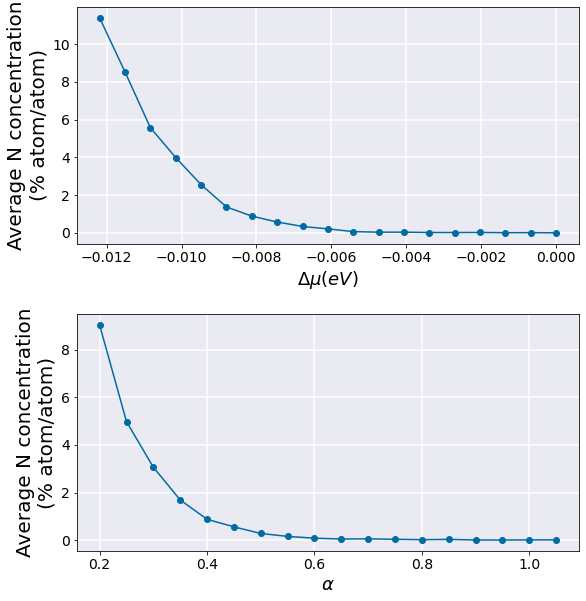

In [ ]:
for i in range(37):
    df_list.append(pd.read_csv('data/qa/QA_g_mu_g_T_av_%s.csv'%i))

fig, axs = plt.subplots(2,1,figsize=(9, 10), sharex=False)

temperature_range = np.append(np.array([1.]*19),np.round(np.arange(0.2,1.1,0.05),5)[::-1]) #Fig 1. all new
chemical_potential_all = np.append(np.round(np.arange(-0.9,0.01,0.05),5)[::-1],np.array([0.]*18))

potential_fraction = chemical_potential_all[0:19]*Q_graphene_ml[0][0]
average_composition = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)*2)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    if j<19:
        
        for i in range(len(index_conc)-1):

            multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
            energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
        mu = np.round(potential_fraction[j],3)
        T = 1.0

        
    else:
        for s,i in enumerate(range(len(index_conc)-1)):

            multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
            energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

        T = temperature_range[j]


axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o-',label='$\Delta\mu$=%s'%(mu))
axs[1].plot(temperature_range[len(potential_fraction):],average_composition[len(potential_fraction):],
               'o-',label='$\Delta\mu$=%s'%(mu))

axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)
axs[0].tick_params(axis='x', labelsize=14)


axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('$\\alpha$',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)


axs[0].set_ylabel('Average N concentration\n(% atom/atom)',fontsize=20)
axs[1].set_ylabel('Average N concentration\n(% atom/atom)',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

axs[1].grid(color='white', linewidth=1.5)
axs[0].grid(color='white', linewidth=1.5)
axs[0].set_facecolor('#EAEAF2')

fig.subplots_adjust(hspace=0.3)

# fig.savefig('/Users/brunocamino/Desktop/graphene_av_potential_T.jpg',dpi=1000)

### Figure X1

#### Potential

In [ ]:
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []

temperature_range = [1.]*5 #Fig 1. all individual mu
chemical_potential_all = np.array([-0.4,-0.6,-0.7,-0.8,-0.9]) #Fig 1. all individual mu

potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]

potential_tmp = chemical_potential_all

bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):

    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)


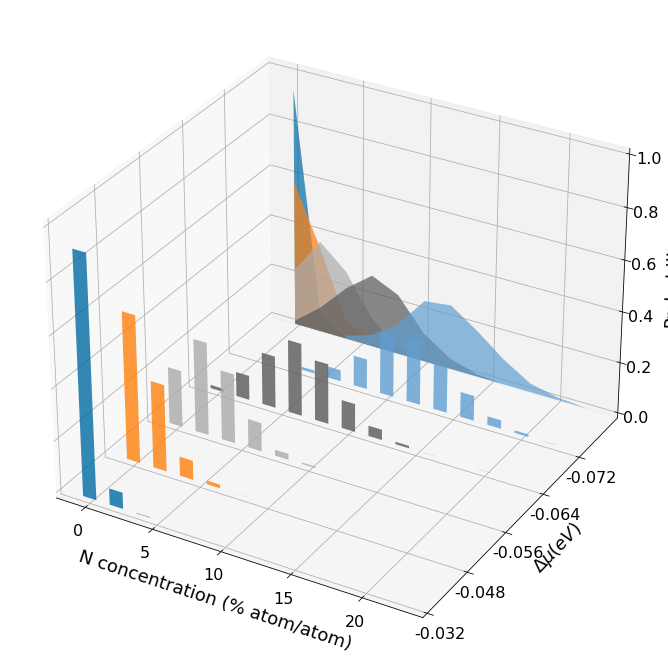

In [ ]:
df_list = []
for i in range(5):
    df_list.append(pd.read_csv('data/qa/QA_g_mu_%s.csv'%i))
    
from matplotlib.collections import PolyCollection
#graph NEW 3D
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(projection='3d')

conc_all = []
prob_all = []

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
for j,ddf in enumerate(df_list):

    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)*2)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    for s,i in enumerate(range(len(index_conc)-1)):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

    conc_all.append(conc.tolist())
    prob_all.append((np.array(multiplicity_unique)/num_reads).tolist())
    T = temperature_range[j]
    axs.bar(conc*2,np.array(multiplicity_unique)/num_reads, zs=j,width=1.,
            alpha=0.8,zdir='y', label='$\\alpha$=%s'%(T))
    line = polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)

    verts = [polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)]

    poly = PolyCollection(verts,facecolors=colors[j], alpha=.7)

    axs.add_collection3d(poly, zs=len(df_list), zdir='y')

    
axs.set_xlabel('N concentration (% atom/atom)',fontsize=18)
axs.set_ylabel('$\Delta\mu (eV)$',fontsize=18,rotation=90)
axs.set_zlabel('Probability',fontsize=18,rotation=90)


custom_yticks = [0,1,2,3,4]
axs.set_yticks(custom_yticks)
axs.set_yticklabels([-0.032, -0.048, -0.056, -0.064, -0.072])
axs.tick_params(axis='x', labelsize=16)
axs.tick_params(axis='y', labelsize=16)
axs.tick_params(axis='z', labelsize=16)
axs.xaxis.labelpad = 10
axs.yaxis.labelpad = 10
axs.zaxis.labelpad = 10

axs.set_ylim([0,len(df_list)])
axs.set_zlim([0,1])

fig.savefig('/Users/brunocamino/Desktop/QA_g_mu.png',dpi=800)

### Figure X1

#### Temperature

In [ ]:
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []

temperature_range = [1.,0.35,0.3,0.25,0.2] #Fig 1. all individual temperature

chemical_potential_all = np.array([0.]*len(temperature_range)) #Fig 1. all individual temperature
potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]


potential_tmp = chemical_potential_all


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):


    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)

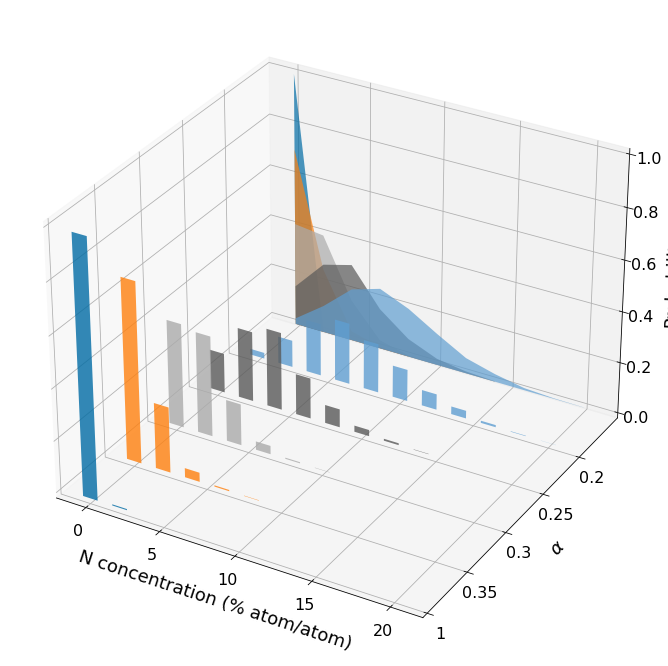

In [ ]:
df_list = []
for i in range(5):
    df_list.append(pd.read_csv('data/qa/QA_g_T_%s.csv'%i))
    
from matplotlib.collections import PolyCollection
#graph NEW 3D
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(projection='3d')

conc_all = []
prob_all = []

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
for j,ddf in enumerate(df_list):

    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)*2)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    for s,i in enumerate(range(len(index_conc)-1)):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

    conc_all.append(conc.tolist())
    prob_all.append((np.array(multiplicity_unique)/num_reads).tolist())
    T = temperature_range[j]
    axs.bar(conc*2,np.array(multiplicity_unique)/num_reads, zs=j,width=1.,
            alpha=0.8,zdir='y', label='$\\alpha$=%s'%(T))
    line = polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)

    verts = [polygon_under_graph(conc*2,np.array(multiplicity_unique)/num_reads)]

    poly = PolyCollection(verts,facecolors=colors[j], alpha=.7)

    axs.add_collection3d(poly, zs=len(df_list), zdir='y')

    
axs.set_xlabel('N concentration (% atom/atom)',fontsize=18)
axs.set_ylabel('$\\alpha$',fontsize=18,rotation=90)
axs.set_zlabel('Probability',fontsize=18,rotation=90)


custom_yticks = [0,1,2,3,4]
axs.set_yticks(custom_yticks)
axs.set_yticklabels([1,0.35,0.30,0.25,0.2])
axs.tick_params(axis='x', labelsize=16)
axs.tick_params(axis='y', labelsize=16)
axs.tick_params(axis='z', labelsize=16)
axs.xaxis.labelpad = 10
axs.yaxis.labelpad = 10
axs.zaxis.labelpad = 10

axs.set_ylim([0,len(df_list)])
axs.set_zlim([0,1])

fig.savefig('/Users/brunocamino/Desktop/QA_g_T.png',dpi=800)

## Figure X2

In [ ]:
#KEEP THIS
graphene_50 = cry_gui2pmg(Crystal_gui().read_gui('data/crystal/graphene/graphene_50.gui'))
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'}))

num_anneal = 1
Q_interaction_binary = copy.deepcopy(Q_graphene_ml)

df_list = []
df_list_1 = []
sampleset_all = []


temperature_range = np.array([0.25,0.25,0.25,0.5,0.5,0.5,1.,1.,1.]) #Fig.2
chemical_potential_all = np.array([0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.72,-0.85])

potential_fraction = chemical_potential_all*Q_graphene_ml[0][0]


bqm_all = []
scale_factor_list = [] 
for i,norm in enumerate(temperature_range):


    Q_binary = Q_interaction_binary 
    bqm = dimod.BQM(Q_binary, "BINARY")

    for linear in bqm.linear.keys():

        bqm.set_linear(linear,+4+4*chemical_potential_all[i])

    J = []
    for i,quadratic in enumerate(bqm.quadratic.keys()):
        J.append(bqm.quadratic[quadratic])

    scaled_J = np.array(J)/max(J)

    for i,quadratic in enumerate(bqm.quadratic.keys()):
        bqm.set_quadratic(quadratic[0],quadratic[1],scaled_J[i])

    bqm.scale(norm)        
    bqm_all.append(bqm)

    for n in range(num_anneal):
        sampleset = sampler.sample(bqm, num_reads=1000,auto_scale=False)
        sampleset_all.append(sampleset)
        if n == 0:
            df_tmp = sampleset.to_pandas_dataframe()
        else:
            df_tmp = pd.concat([df_tmp, sampleset.to_pandas_dataframe()], ignore_index=True)
    df_list.append(df_tmp)

In [ ]:
#mu_QUBO_all = np.array([0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.795,-0.85])*Q_graphene_ml[0][0]
mu_QUBO_all = np.array(potential_tmp)*Q_graphene_ml[0][0]
T_all = [355,350,350,160,160,160,50,50,50]
for i in range(9):
    unique_energies,probability_energy = get_qubo_probability(mu=mu_QUBO_all[i],temperature=T_all[i])
    np.savetxt('data/qa/QUBO_%s.csv'%i, probability_energy, delimiter=',')
np.savetxt('data/qa/unique_energy.csv', unique_energies, delimiter=',')

In [ ]:
mu_QUBO_all

array([ 0.        , -0.00406195, -0.00541593,  0.        , -0.0081239 ,
       -0.00947788,  0.        , -0.00974868, -0.01150886])

In [ ]:
np.savetxt('data/qa/unique_energy.csv', unique_energies, delimiter=',')

### I need to save the QUBO old to plot this

In [ ]:
temperature_range = [0.25,0.25,0.25,0.5,0.5,0.5,1.,1.,1.]
potential_tmp = np.array([0.,-0.3,-0.4,0.,-0.6,-0.7,0.,-0.72,-0.85])
potential_fraction = potential_tmp*Q_graphene_ml[0][0]

fig, axs = plt.subplots(3,3,figsize=(18, 12), sharey=False,sharex=False)
T_all = [200,200,200,50,50,50,20,14,20]
T_all = [310,350,370,160,150,155,50,80,85]
# # EXHAUSTIVE SEARCH


shaded_areas_i = []
shaded_areas_f = []
for i in range(0,6):
    shaded_areas_i.append(np.min(np.array(graphene_allN_qubo_energy_list[i])))
    shaded_areas_f.append(np.max(np.array(graphene_allN_qubo_energy_list[i])))

df_list = []
for i in range(9):
    df_list.append(pd.read_csv('data/qa/QA_graphene_mu_T_%s.csv'%i))
    
unique_energies = np.loadtxt('data/qa/unique_energy.csv', delimiter=",", dtype=float)

for j,ddf in enumerate(df_list):
    m = j%3
    n = int((j-m)/3)
    mu = np.round(potential_tmp[j]*Q_graphene_ml[0][0],3)
    # EXHAUSTIVE SEARCH
    
    
    unique_energies,probability_energy = get_qubo_probability(mu=potential_fraction[j],temperature=T_all[j])
    

    zero_values = np.where(np.array(probability_energy) <0.00001)
    unique_energies = np.delete(unique_energies,zero_values)
    probability_energy = np.delete(probability_energy,zero_values)
    
    
    axs[n][m].bar(unique_energies,probability_energy,width=0.009,
                  alpha=0.6,label='ES ($\Delta\mu$=%s,T=%sK)'%(mu,T_all[j]))

    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:50].to_numpy()
    energy = []
    for config in configurations:
        energy.append(classical_energy(config,Q_graphene_ml))
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),50,7)
    
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))

    
    index = np.unique(dddf.sort_values(by='energy')['energy'].to_numpy(),return_counts=True,return_index=True)[1]
    index = np.append(index,len(dddf))
    multiplicity = dddf.sort_values(by='energy')['num_occurrences'].to_numpy()

    energy = np.unique(dddf.sort_values(by='energy')['energy'].to_numpy())
    multiplicity_unique = []
    for i in range(len(index)-1):

        multiplicity_unique.append(np.sum(multiplicity[index[i]:index[i+1]]))

    #### PARTITION FUNCTION ####
    probability = (get_partition_function(energy,multiplicity_unique, T=298.15))[1]
    mu = np.round(potential_tmp[j]*Q_graphene_ml[0][0],3)
    T = temperature_range[j]

    axs[n][m].bar(energy,np.array(multiplicity_unique)/num_reads,width=0.009,
                alpha=0.6,label='QA ($\Delta\mu$=%s,$\\alpha$=%s)'%(mu,T))    

    
    axs[n][m].set_xlim([-0.03,shaded_areas_f[-1]])
    axs[n][m].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
    axs[n][m].set_xticklabels([0.  , 0.03, 0.06, 0.09, 0.12, 0.15]) #rescaling for new QUBO
    if m == 2:
        axs[m][n].set_xlabel('$\Delta$E$^{f}$ (eV)',fontsize=20) 
    if n == 0:
        axs[m][n].set_ylabel('p$_{i}$',fontsize=20)
    axs[m][n].tick_params(axis='x', labelsize=14)
    axs[m][n].tick_params(axis='y', labelsize=14)

    
    max_y = np.max([np.max(np.array(multiplicity_unique)/num_reads),np.max(probability_energy)])

    max_y = max_y + max_y*0.7
    if max_y > 1.:
        max_y = 1.2
    axs[n][m].set_ylim([0.,max_y])
    axs[n][m].legend(bbox_to_anchor=(1., 0.85),loc='upper right')
    
    colors = ['#CECECE','#DEDEDE']
    
    hatchs = ['//','\\\\']
    text = ['0%N','2%N','4%N','6%N','8%N','10%N','12%N','14%N']
    
    for k,h in enumerate(shaded_areas_i):
        axs[m][n].axvspan(shaded_areas_i[k], shaded_areas_f[k], color=colors[0], hatch=hatchs[k%2], alpha=0.3,)
        if n >-1:
            midpoint = (shaded_areas_i[k] + shaded_areas_f[k]) / 2
            axs[n][m].text(midpoint, max_y-0.1*max_y, text[k], ha='center', va='center', fontsize=14, color='black')#,fontweight='bold')

# fig.savefig('/Users/brunocamino/Desktop/graphene_QA_QUBO_T_mu',dpi=800)

# <a id='anneal_binary_gaaln'>Ga/AlN</a>


## Average concentration vs chemical potential (alpha=1.0)

In [45]:
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

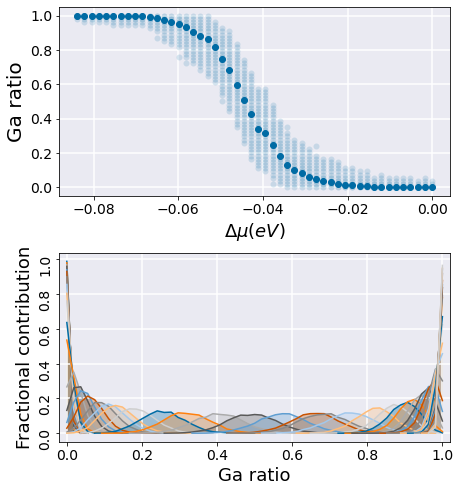

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:54].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/54)
    std_conc.append(np.std(np.sum(configurations,axis=1)/54))

    min_conc.append(np.min(np.sum(configurations,axis=1))/54)
    max_conc.append(np.max(np.sum(configurations,axis=1))/54)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_gaaln_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),54,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/54,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/54,conc_mult/num_reads, alpha=0.3)
    


    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/54,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ga ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

## Average concentration vs chemical potential (alpha=0.5)

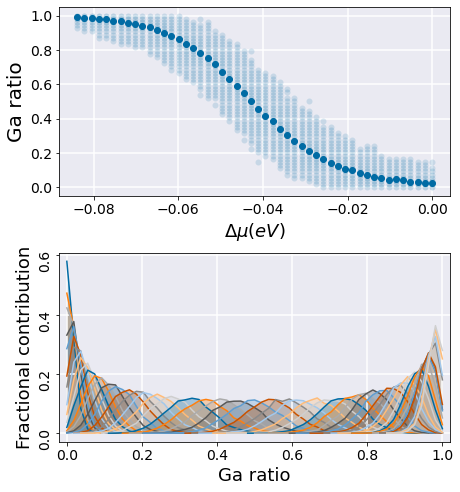

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-1.8,0,50),5)
potential_fraction = chemical_potential_all*Q_gaaln_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('data/qa/GaAlN/chemical_potential/QA_gaaln_mu_av_alpha_0.5_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)


average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:54].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/54)
    std_conc.append(np.std(np.sum(configurations,axis=1)/54))

    min_conc.append(np.min(np.sum(configurations,axis=1))/54)
    max_conc.append(np.max(np.sum(configurations,axis=1))/54)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_gaaln_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),54,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/54,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/54,conc_mult/num_reads, alpha=0.3)
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/54,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ga ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

# fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

### Read Band Gap

In [ ]:
E_gap_1 = []
E_1 = []
for i in range(55):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1/GaAlN_{}.out'.format(i))
    E_gap_1.append(crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1.append(energy_norm)

# E_1[0] = (E_aln - (E_al*54) )/54
# E_1[-1] = (E_gan - (E_ga*54) )/54
    
E_gap_1[0]  = 6.2643
E_gap_1[-1] = 3.7855

E_gap_1 = np.array(E_gap_1)
E_1 = np.array(E_1)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_1_exc = []
E_1_exc = []
state = 1
for i in range(2,53):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1_excited/GaAlN_{}.out'.format(i))
    E_gap_1_exc.append(crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1_exc.append(energy_norm)

E_1_exc.insert(0,0.)
E_1_exc.insert(1,0.)
E_1_exc.append(0.)
E_1_exc.append(0.)

    
E_gap_1_exc.insert(0,E_gap_1[0])
E_gap_1_exc.insert(1,E_gap_1[1])
E_gap_1_exc.append(E_gap_1[-2])
E_gap_1_exc.append(E_gap_1[-1])

E_gap_1_exc = np.array(E_gap_1_exc)
E_1_exc = np.array(E_1_exc)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_1_exc_2 = []
E_1_exc_2 = []
for i in range(2,53):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1_excited_2/GaAlN_{}.out'.format(i))
    E_gap_1_exc_2.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1_exc_2.append(energy_norm)

E_1_exc_2.insert(0,0.)
E_1_exc_2.insert(1,0.)
E_1_exc_2.append(0.)
E_1_exc_2.append(0.)

E_gap_1_exc_2.insert(0,E_gap_1[0])
E_gap_1_exc_2.insert(1,E_gap_1[1])
E_gap_1_exc_2.append(E_gap_1[-2])
E_gap_1_exc_2.append(E_gap_1[-1])
E_gap_1_exc_2 = np.array(E_gap_1_exc_2)
E_1_exc_2 = np.array(E_1_exc_2)

/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/crystal_io.py:192: UserWarning: Deprecated. Define output during initialization.
  warnings.warn('Deprecated. Define output during initialization.')


In [ ]:
E_gap_1_exc_3 = []
for i in range(3,52):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1_excited_3/GaAlN_{}.out'.format(i))
    E_gap_1_exc_3.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
E_gap_1_exc_3.insert(0,E_gap_1[0])
E_gap_1_exc_3.insert(1,E_gap_1[1])
E_gap_1_exc_3.insert(2,E_gap_1[2])
E_gap_1_exc_3.append(E_gap_1[-3])
E_gap_1_exc_3.append(E_gap_1[-2])
E_gap_1_exc_3.append(E_gap_1[-1])
E_gap_1_exc_3 = np.array(E_gap_1_exc_3)

In [ ]:
E_gap_1_exc_4 = []
for i in range(3,52):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1_excited_4/GaAlN_{}.out'.format(i))
    E_gap_1_exc_4.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
E_gap_1_exc_4.insert(0,E_gap_1[0])
E_gap_1_exc_4.insert(1,E_gap_1[1])
E_gap_1_exc_4.insert(2,E_gap_1[2])
E_gap_1_exc_4.append(E_gap_1[-3])
E_gap_1_exc_4.append(E_gap_1[-2])
E_gap_1_exc_4.append(E_gap_1[-1])
E_gap_1_exc_4 = np.array(E_gap_1_exc_4)

In [ ]:
E_gap_1_max_p = []
for i in range(2,53):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1_max_p/GaAlN_{}.out'.format(i))
    E_gap_1_max_p.append(crystal_output.get_band_gap())
    #print('GaAlN_{}.out'.format(i),crystal_output.get_band_gap())
E_gap_1_max_p.insert(0,E_gap_1[0])
E_gap_1_max_p.insert(1,E_gap_1[1])
# E_gap_1_max_p.insert(2,E_gap_1[2])
# E_gap_1_max_p.append(E_gap_1[-3])
E_gap_1_max_p.append(E_gap_1[-2])
E_gap_1_max_p.append(E_gap_1[-1])
E_gap_1_max_p = np.array(E_gap_1_max_p)

In [ ]:
E_gap_1_exc_last = []
E_1_exc_last = []
for i in range(3,52):
    crystal_output = Crystal_output().read_cry_output('data/crystal/GaAlN/mace/gap/1_excited_last/GaAlN_{}.out'.format(i))
    E_gap_1_exc_last.append(crystal_output.get_band_gap())
    energy_norm = (crystal_output.get_final_energy() - 
                   (E_al*(54-i)) - (E_ga*i))/54 
    E_1_exc_last.append(energy_norm)
    
E_gap_1_exc_last.insert(0,E_gap_1[0])
E_gap_1_exc_last.insert(1,E_gap_1[1])
E_gap_1_exc_last.insert(2,E_gap_1[2])
E_gap_1_exc_last.append(E_gap_1[-3])
E_gap_1_exc_last.append(E_gap_1[-2])
E_gap_1_exc_last.append(E_gap_1[-1])

E_1_exc_last.insert(0,E_gap_1[0])
E_1_exc_last.insert(1,E_gap_1[1])
E_1_exc_last.insert(2,E_gap_1[2])
E_1_exc_last.append(E_gap_1[-3])
E_1_exc_last.append(E_gap_1[-2])
E_1_exc_last.append(E_gap_1[-1])

E_gap_1_exc_last = np.array(E_gap_1_exc_last)
E_1_exc_last = np.array(E_1_exc_last)

In [ ]:
E_gap_1_all = [E_gap_1,E_gap_1_exc,E_gap_1_exc_2,E_gap_1_exc_3,E_gap_1_exc_4,E_gap_1_max_p,E_gap_1_exc_last]
E_gap_1_all = np.array(E_gap_1_all)

## Grand canonical

In [ ]:
df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('qa/GaAlN/new_Q/QA_gaaln_mu_av_alpha_0.5_%s.csv'%i))
df_all = copy.deepcopy(df_list[0])
for df in df_list:
    df_all = pd.concat([df_all, df], ignore_index=True)

In [ ]:
config_all = df_all.iloc[:,0:54].to_numpy()
conc_all = np.sum(df_all.iloc[:,0:54].to_numpy(),axis=1)
conc_all_unique = np.unique(conc_all)
energies_all = []
for config in config_all:
    energies_all.append(np.round(classical_energy(config,Q_gaaln_ml),5))

In [ ]:
E_gap_gc_1 = []
for mu in range(len(conc_unique_all)):
    #print(conc_unique_all[mu])
    E_gap_gc_1.append(np.average(E_gap_1[conc_unique_all[mu]],weights=conc_mult_all[mu]))
    #E_gap_gc.append()

In [ ]:
states = 1
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
states = 2
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_2 = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_2.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
states = 3
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_3 = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_3.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
states = 4
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_4 = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_4.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
# THIS IS FOR THE MAX PROB ONLY
# states = 'max_p'
# E_gap_gc_1_max_p = []
# for mu in range(len(conc_unique_all)):
#     E_gap_gc_1_max_p.append(np.average(E_gap_1_max_p[conc_unique_all[mu]],weights=conc_mult_all[mu]))
    
states = 5
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_max_p = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_max_p.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
# THIS IS FOR THE LAST STATE ONLY
states = 'last'
E_gap_gc_1_exc_last_only = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_last_only.append(np.average(E_gap_1_exc_last[conc_unique_all[mu]],weights=conc_mult_all[mu]))

states = 6
E_gap_tmp = np.average(E_gap_1_all[0:states+1,:],axis=0,weights=unique_counts_all[:,0:states+1].T)
E_gap_gc_1_exc_last = []
for mu in range(len(conc_unique_all)):
    E_gap_gc_1_exc_last.append(np.average(E_gap_tmp[conc_unique_all[mu]],weights=conc_mult_all[mu]))

In [ ]:
E_gap_gc_all = [E_gap_gc_1,E_gap_gc_1_exc,E_gap_gc_1_exc_2,E_gap_gc_1_exc_3,
                E_gap_gc_1_exc_4,E_gap_gc_1_max_p,E_gap_gc_1_exc_last]

In [ ]:
E_gap_all = [E_gap_1,E_gap_1_exc,E_gap_1_exc_2,E_gap_1_exc_3,
             E_gap_1_exc_4,E_gap_1_max_p,E_gap_1_exc_last]
labels = ['Ground state','1st excited state','2nd excited state','3rd excited state',
          '4th excited state','max_p','last QUBO es']
for i,gap in enumerate(E_gap_gc_all):

    plt.plot(np.arange(4,51)/54,np.array(gap[3:52])-np.array(E_gap_gc_1[3:52]),'-',label=labels[i])
#     plt.plot(np.arange(1,54)/54,np.array(gap[3:52])-np.array(E_gap_1[3:52]),'-',label=labels[i])
plt.legend()
plt.xlabel('Ga Ratio',fontsize=14)
plt.ylabel('Delta E_g',fontsize=14)

## Band gap plots

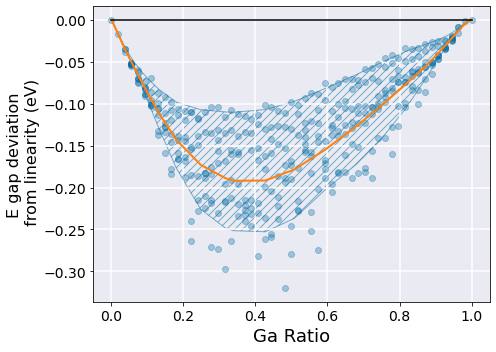

In [ ]:
#SAVE
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
colors = ['#006BA450', '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
fig, axs = plt.subplots(1, figsize=(7, 5),sharex=False)
E_gap_gc_all = [E_gap_gc_1,E_gap_gc_1_exc,E_gap_gc_1_exc_2,E_gap_gc_1_exc_3,
                E_gap_gc_1_exc_4,E_gap_gc_1_max_p,E_gap_gc_1_exc_last]
labels = ['gs','gs->1es','gs->2es','gs->3es','gs->4es','max_p','last es']
x0 = 0
x1 = 1
y0 = E_gap_1[0]
y1 = E_gap_1[-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_1-(np.arange(55)/54)*slope)[0]
axs.plot(np.arange(55)/54,(E_gap_1-(np.arange(55)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc gs')

# x0 = 0
# x1 = 1
# y0 = E_gap_1_exc[0]
# y1 = E_gap_1_exc[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap_1_exc-(np.arange(55)/54)*slope)[0]
axs.plot(np.arange(2,53)/54,(E_gap_1_exc[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 1es')

# x0 = 0
# x1 = 1
# y0 = E_gap_1_exc_2[0]
# y1 = E_gap_1_exc_2[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap_1_exc_2-(np.arange(len(E_gap_1_exc_2))/54)*slope)[0]
axs.plot(np.arange(2,53)/54,(E_gap_1_exc_2[2:-2]-(np.arange(2,53)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 2es')

# x0 = 0
# x1 = 1
# y0 = E_gap_1_exc_3[0]
# y1 = E_gap_1_exc_3[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap_1_exc_3-(np.arange(len(E_gap_1_exc_3))/54)*slope)[0]
axs.plot(np.arange(3,52)/54,(E_gap_1_exc_3[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 3es')

axs.plot(np.arange(3,52)/54,(E_gap_1_exc_4[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc 4es')
axs.plot(np.arange(3,52)/54,(E_gap_1_max_p[3:-3]-(np.arange(3,52)/54)*slope)-yy1,'o',color=colors[0],label='Fixed conc max_p')
axs.plot(np.arange(3,52)/54,(E_gap_1_exc_last[3:-3]-(np.arange(3,52)/54)*slope)-yy1,
         'o',color=colors[0],label='Fixed conc last')



# Egx_formula = (fx+b[24]*average_composition*(1-average_composition))
# x0 = 0
# x1 = 1
# y0 = E_gap[0]
# y1 = E_gap[-1]
# slope = (y1-y0)/(x1-x0)
# yy1 = (E_gap-(np.arange(55)/54)*slope)[0]
# #axs.plot(average_composition,b[24]*average_composition*(1-average_composition),'--',label='Test')
# #axs.plot(average_composition,-1.07*average_composition*(1-average_composition),'k--',label='Test')
# axs.plot(average_composition,-0.53*average_composition*(1-average_composition),'k--',label='Test')


for i in [5]:
    #print(i)
    #average_composition = np.array(average_composition_all[i])
    x0 = average_composition[0]
    x1 = average_composition[-1]
    y0 = E_gap_gc_all[i][0]
    y1 = E_gap_gc_all[i][-1]
    slope = (y1-y0)/(x1-x0)
    #plt.plot(average_composition,average_composition*slope)
    yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
    axs.plot(average_composition,((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1),
             '-',color = colors[1],label=labels[i],linewidth=2)#'Averaged 0-{}'.format(i))
    #print((E_gap_gc_all[i]-average_composition*slope),y1)
    #print(np.round((E_gap_gc_all[i]-np.array(average_composition)*slope)-yy1,2))
axs.plot([0,1],[0,0],'k-')

# FILL BETWEEN

x0 = average_composition[0]
x1 = average_composition[-1]
y0 = E_gap_gc_all[i][0]
y1 = E_gap_gc_all[i][-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
top = ((E_gap_gc_1_exc_last_only-np.array(average_composition)*slope)-yy1)


x0 = average_composition[0]
x1 = average_composition[-1]
y0 = E_gap_gc_all[i][0]
y1 = E_gap_gc_all[i][-1]
slope = (y1-y0)/(x1-x0)
yy1 = (E_gap_gc_all[i]-np.array(average_composition)*slope)[0]
bottom = ((E_gap_gc_all[0]-np.array(average_composition)*slope)-yy1)

axs.fill_between(average_composition,top,bottom,hatch='///', edgecolor='#006BA450', facecolor='none', alpha=0.5)

#axs.plot(average_composition,(E_gap_gc_5-np.array(average_composition)*slope)-yy1,'o-',label='gc (low E)')

axs.grid()
axs.grid(color='white', linewidth=1.5)

axs.set_facecolor('#EAEAF2')

axs.set_xlabel('Ga Ratio',fontsize=18)
axs.set_ylabel('E gap deviation\n from linearity (eV)',fontsize=16)

#axs.set_yticks(np.arange(4.6,6.5,0.3))
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
# axs.legend()
plt.tight_layout()
axs.set_xlim([-0.05,1.05])
fig.savefig('/Users/brunocamino/Desktop/E_gap_deviation.jpg',dpi=1000,bbox_inches='tight')

#plt.plot(np.arange(55)/54,E_gap-(np.arange(55)/54)*slope-y0,'-')

# <a id='anneal_binary_wmo'>TaW</a>


## TaW new Q (alpha=1.0)

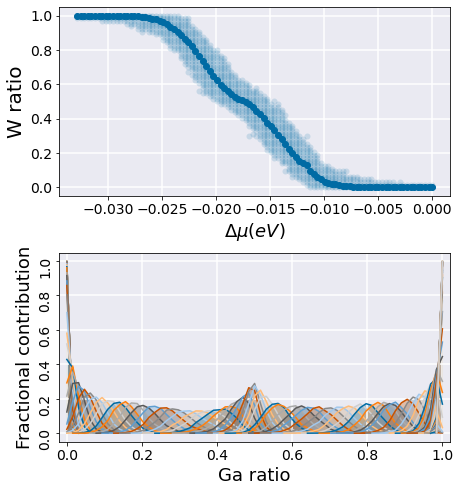

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-2.5,0.,100),5)
potential_fraction = chemical_potential_all*Q_taw_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('data/qa/TaW/QA_taw_mu_av_alpha_1.0_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:64].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/64)
    std_conc.append(np.std(np.sum(configurations,axis=1)/64))

    min_conc.append(np.min(np.sum(configurations,axis=1))/64)
    max_conc.append(np.max(np.sum(configurations,axis=1))/64)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
 
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_taw_ml))
  
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),64,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/64,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/64,conc_mult/num_reads, alpha=0.3)
    


    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/64,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('W ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
#axs[1][0].tick_params(axis='y', labelsize=14)
# axs[0][1].legend(fontsize=14)
# axs[1][1].legend(fontsize=14)
#axs[0].grid()
axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')
#axs[1][0].set_facecolor('#EAEAF2')
#axs[0][1].set_title('Chemical potential',fontsize=18)
#axs[1][1].set_title('Temperature',fontsize=18)
#fig.text(0.5, 0.9, '   Chemical potential', ha='center', va='center', fontsize=18)
#fig.text(0.5, 0.48, '   Temperature', ha='center', va='center', fontsize=18)

fig.subplots_adjust(hspace=0.3)
#axs[1].legend()

#fig.suptitle('  N-doped graphene', fontsize=20,y=0.95)

fig.savefig('/Users/brunocamino/Desktop/GaAlN_average_conc.jpg',dpi=1000)

## TaW new Q (alpha=0.5)

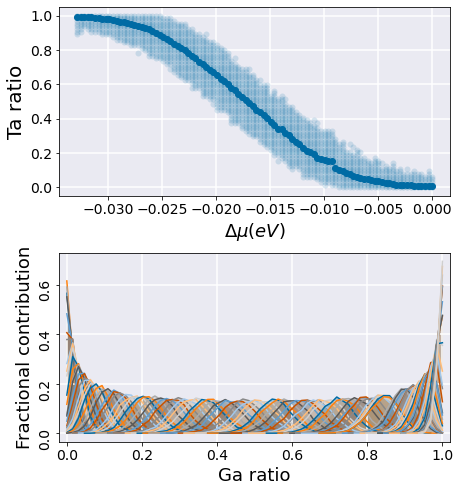

In [ ]:
#Fig 1 all 4 subplots
chemical_potential_all = np.round(np.linspace(-2.5,0.,100),5)
potential_fraction = chemical_potential_all*Q_taw_ml[0][0]

df_list = []
for i in range(len(chemical_potential_all)):
    df_list.append(pd.read_csv('data/qa/TaW/QA_taw_mu_av_alpha_0.5_%s.csv'%i))



fig, axs = plt.subplots(2,1,figsize=(7, 8), sharex=False)

average_composition = []
conc_unique_all = []
conc_mult_all = []
min_conc = []
max_conc = []
std_conc = []
for j,ddf in enumerate(df_list):
    
    num_reads = np.sum(ddf['num_occurrences'].to_numpy())
    configurations = ddf.iloc[:,0:64].to_numpy()
    energy = []
    weights = ddf['num_occurrences'].to_numpy()
    
    average_composition.append(np.average(np.sum(configurations,axis=1),weights=weights)/64)
    std_conc.append(np.std(np.sum(configurations,axis=1)/64))

    min_conc.append(np.min(np.sum(configurations,axis=1))/64)
    max_conc.append(np.max(np.sum(configurations,axis=1))/64)
    
    conc_unique = np.unique(np.sum(configurations,axis=1))
    conc_mult = []
    for conc in conc_unique:
        conc_index = np.where(np.sum(configurations,axis=1) == conc)
        conc_mult.append(np.sum(weights[conc_index]))
    #print(conc_unique,conc_mult)
    conc_unique_all.append(conc_unique)
    conc_mult_all.append(conc_mult)
    for config in configurations:
        
        energy.append(classical_energy(config,Q_taw_ml))
    
    
    #E_gap_gc.append()
    
    dddf = copy.deepcopy(ddf)
    dddf['energy'] = np.round(np.array(energy),5)
    
    dddf = add_num_dopant(convert_df_binary2atom(dddf,[6,7]),64,7)
        
    index_conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy(),return_counts=True,return_index=True)[1]
    conc = np.unique(dddf.sort_values(by='num_dopants')['num_dopants'].to_numpy())
    index_conc = np.append(index_conc,len(dddf))

    multiplicity = dddf.sort_values(by='num_dopants')['num_occurrences'].to_numpy()
    multiplicity_unique = []
    energy_average = []
    energy = dddf.sort_values(by='num_dopants')['energy'].to_numpy()
    
    
    
        
    for i in range(len(index_conc)-1):

        multiplicity_unique.append(np.sum(multiplicity[index_conc[i]:index_conc[i+1]]))
        energy_average.append(np.average(energy[index_conc[i]:index_conc[i+1]],weights=multiplicity[index_conc[i]:index_conc[i+1]]))
    mu = np.round(potential_fraction[j],3)
    T = 1.0

    axs[1].plot(1-conc_unique/64,conc_mult/num_reads,'-',label='{}'.format(np.round(potential_fraction[j],3)))  
    axs[1].fill_between(1-conc_unique/64,conc_mult/num_reads, alpha=0.3)
    

    for k in range(len(conc_unique)): 
        values = (conc_mult/num_reads)[k] 
        axs[0].plot(potential_fraction[j],conc_unique[k]/64,'o',color='#006BA4',
                    markeredgecolor='none',alpha=values * 0.25 + 0.15 )

axs[0].plot(potential_fraction,average_composition[0:len(potential_fraction)],
               'o',label='$\Delta\mu$=%s'%(mu))


axs[0].set_xlabel('N concentration (% atom/atom)',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)



axs[0].set_ylabel('p$_{i}$',fontsize=20)

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='y', labelsize=14)

axs[0].grid()
axs[0].grid(color='white', linewidth=1.5)

axs[0].set_facecolor('#EAEAF2')
axs[1].set_facecolor('#EAEAF2')

axs[0].set_xlabel('$\Delta\mu (eV)$',fontsize=18)
axs[1].set_xlabel('Ga ratio',fontsize=18)

axs[0].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', rotation=90)
# ax2.tick_params(axis='y', labelsize=14)


axs[0].set_ylabel('Ta ratio',fontsize=20)
axs[1].set_ylabel('Fractional contribution',fontsize=18)

axs[0].set_ylim([-0.05,1.05])
axs[1].set_xlim([-0.02,1.02])

custom_xticks = np.arange(0,23,2)

axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

axs[1].grid(color='white', linewidth=1.5,zorder=0)
axs[0].grid(color='white', linewidth=1.5,zorder=0)
axs[0].set_facecolor('#EAEAF2')

fig.subplots_adjust(hspace=0.3)

# fig.savefig('/Users/brunocamino/Desktop/TaW_average_conc.jpg',dpi=1000)

# Elastic modulus

#### Experimental

Text(0.5, 1.0, 'Experimental C11')

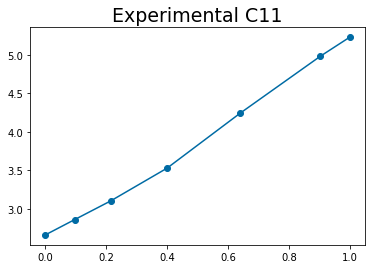

In [ ]:
W_conc_exp = np.array([0.,9.6,21.5,40.0,64.,90.4,100])/100
C11_exp = [2.6600,2.8579,3.1018,3.5267,4.240,4.9812,5.2269]
plt.plot(W_conc_exp,C11_exp,'o-')
plt.title('Experimental C11',fontsize=19)

Text(0.5, 1.0, 'Experimental C44')

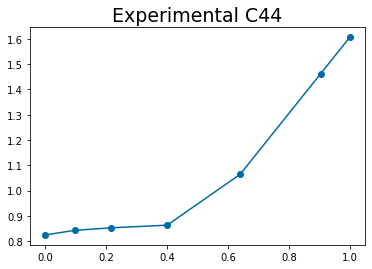

In [ ]:
W_conc_exp = np.array([0.,9.6,21.5,40.0,64.,90.4,100])/100
C44_exp = [0.8247,0.8427,0.8527,0.8632,1.0645,1.4614,1.6060]
plt.plot(W_conc_exp,C44_exp,'o-')
plt.title('Experimental C44',fontsize=19)

Text(0.5, 1.0, 'Experimental Bulk Modulus')

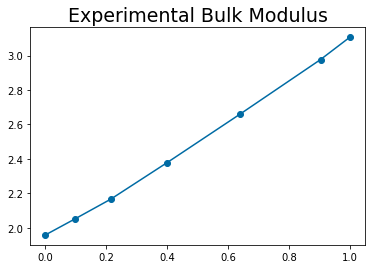

In [ ]:
W_conc_exp = np.array([0.,9.6,21.5,40.0,64.,90.4,100])/100
K_exp = [1.9596,2.0514,2.1673,2.3791,2.6608,2.9767,3.1060]
plt.plot(W_conc_exp,K_exp,'o-')
plt.title('Experimental Bulk Modulus',fontsize=19)

In [ ]:
from pymatgen.io.vasp import Poscar
from pymatgen.core import Structure

state = 1  # or whatever value state should have
folder = ['ground','1_excited_state']
structures = []

for i in range(0, 65):
    file_name = 'data/vasp/TaW/elastic/{}/elastic/TaW_{}_{}.poscar'.format(folder[state],i, state)
    try:
        poscar = Poscar.from_file(file_name)
        structure = poscar.structure
        structures.append(structure)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")


In [ ]:
state = '0'
elastic_moduli_all_g = []
for i in range(65):
    file_name = 'TaW_{}_{}.outcar'.format(i,state)
    with open('data/vasp/TaW/elastic/ground/elastic/{}'.format(file_name)) as f:
        text = f.readlines()
    elastic_moduli_all_g.append(extract_elastic_moduli(text))
elastic_moduli_all_g = np.array(elastic_moduli_all_g)

In [ ]:
state = '1'
elastic_moduli_all_1 = []
for i in range(65):
    file_name = 'TaW_{}_{}.outcar'.format(i,state)
    with open('data/vasp/TaW/elastic/1_excited_state/elastic/{}'.format(file_name)) as f:
        text = f.readlines()
    elastic_moduli_all_1.append(extract_elastic_moduli(text))
elastic_moduli_all_1 = np.array(elastic_moduli_all_1)

In [ ]:
C11_all = []
C44_all = []
C12_all = []
for i in range(65):
    C11_g = np.average([elastic_moduli_all_g[i,0,0],elastic_moduli_all_g[i,1,1],elastic_moduli_all_g[i,2,2]])
    C44_g = np.average([elastic_moduli_all_g[i,3,3],elastic_moduli_all_g[i,4,4],elastic_moduli_all_g[i,5,5]])
    C12_g = np.average([elastic_moduli_all_g[i,0,1],elastic_moduli_all_g[i,0,2],
            elastic_moduli_all_g[i,1,0],elastic_moduli_all_g[i,1,2],
            elastic_moduli_all_g[i,2,0],elastic_moduli_all_g[i,2,1]])
    
    C11_1 = np.average([elastic_moduli_all_1[i,0,0],elastic_moduli_all_1[i,1,1],elastic_moduli_all_1[i,2,2]])
    C44_1 = np.average([elastic_moduli_all_1[i,3,3],elastic_moduli_all_1[i,4,4],elastic_moduli_all_1[i,5,5]])
    C12_1 = np.average([elastic_moduli_all_1[i,0,1],elastic_moduli_all_1[i,0,2],
            elastic_moduli_all_1[i,1,0],elastic_moduli_all_1[i,1,2],
            elastic_moduli_all_1[i,2,0],elastic_moduli_all_1[i,2,1]])
    
    C11_all.append(np.average([C11_g,C11_1]))
    C44_all.append(np.average([C44_g,C44_1]))
    C12_all.append(np.average([C12_g,C12_1]))

C11_all = np.array(C11_all)
C44_all = np.array(C44_all)
C12_all = np.array(C12_all)
K = np.sum([C11_all,2*C12_all],axis=0)/3

Text(0.5, 1.0, 'C11')

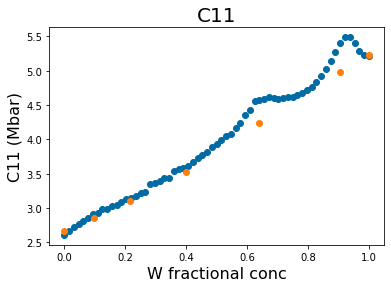

In [ ]:
plt.plot(np.arange(65)/64,C11_all/1000,'o')

plt.plot(W_conc_exp,C11_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C11 (Mbar)',fontsize=16)
plt.title('C11',fontsize=20)

Text(0.5, 1.0, 'C44')

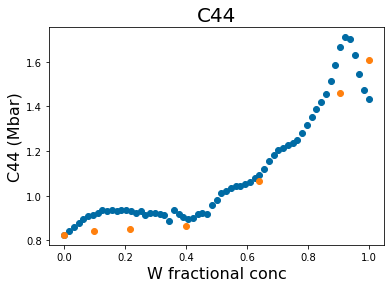

In [ ]:
shift = (C44_all[0])/1000- C44_exp[0]
# shift=0
plt.plot(np.arange(65)/64,(C44_all/1000)-shift,'o')

plt.plot(W_conc_exp,C44_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C44 (Mbar)',fontsize=16)
plt.title('C44',fontsize=20)

### Grand canonical

In [ ]:
C11_gc = []
for mu in range(len(conc_unique_all)):
    C11_gc.append(np.average(C11_all[conc_unique_all[mu]],weights=conc_mult_all[mu]))
C11_gc = np.array(C11_gc)

In [ ]:
C44_gc = []
for mu in range(len(conc_unique_all)):
    C44_gc.append(np.average(C44_all[conc_unique_all[mu]],weights=conc_mult_all[mu]))
C44_gc = np.array(C44_gc)

In [ ]:
K_gc = []
for mu in range(len(conc_unique_all)):
    K_gc.append(np.average(K[conc_unique_all[mu]],weights=conc_mult_all[mu]))
K_gc = np.array(K_gc)

shift=  0


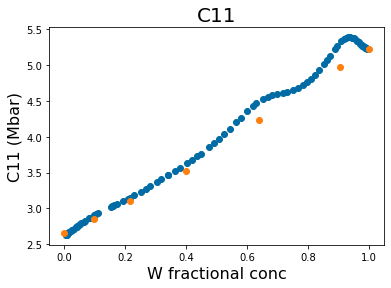

In [ ]:
shift = np.average([(C11_all[0]/1000- C11_exp[0]),(C11_all[-1]/1000- C11_exp[-1])])
shift = (C11_all[0]/1000- C11_exp[0])
shift = 0
plt.plot(average_composition,C11_gc/1000-shift,'o')
# plt.plot(np.arange(65)/64,C11_all/1000,'o')
plt.plot(W_conc_exp,C11_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C11 (Mbar)',fontsize=16)
plt.title('C11',fontsize=20)
print('shift= ', round(shift,4))

shift=  0


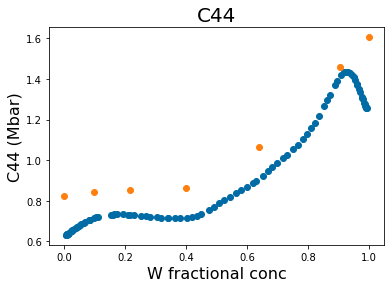

In [ ]:
shift = np.average([(C44_all[0]/1000- C44_exp[0]),(C44_all[-1]/1000- C44_exp[-1])])
shift = (C44_all[0]/1000- C44_exp[0])
shift = 0
plt.plot(average_composition,(C44_gc/1000)-shift,'o')
# plt.plot(np.arange(65)/64,C11_all/1000,'o')
plt.plot(W_conc_exp,C44_exp,'o')
plt.xlabel('W fractional conc',fontsize=16)
plt.ylabel('C44 (Mbar)',fontsize=16)
plt.title('C44',fontsize=20)
print('shift= ', round(shift,4))

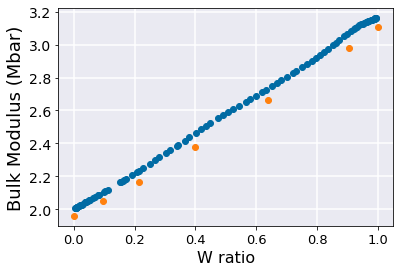

In [ ]:
fig, axs = plt.subplots(1, sharex=False)
# shift = np.average([(K[0]/1000- K_exp[0]),(K[-1]/1000- K_exp[-1])])
# shift = (K[0])/1000- K_exp[0]
shift = 0
axs.plot(average_composition,(K_gc/1000)-shift,'o')
# axs.plot(np.linspace(0,1,65),(K/1000)-shift,'o',color='k')
# plt.plot(np.arange(65)/64,C11_all/1000,'o')
axs.plot(W_conc_exp,K_exp,'o')
axs.set_xlabel('W ratio',fontsize=16)
axs.set_ylabel('Bulk Modulus (Mbar)',fontsize=18)
# axs.set_title('Bulk Modulus',fontsize=20)

axs.grid()
axs.grid(color='white', linewidth=1.5)
axs.tick_params(axis='x', labelsize=13)
axs.tick_params(axis='y', labelsize=14)
axs.set_facecolor('#EAEAF2')

# axs.set_xlabel('Ga Ratio',fontsize=18)
# axs.set_ylabel('E gap (eV)',fontsize=18)

# plt.grid(color='white', linewidth=1.5,zorder=0)
# plt.grid(color='white', linewidth=1.5,zorder=0)
# plt.facecolor('#EAEAF2')

fig.savefig('/Users/brunocamino/Desktop/bulk_modulus.jpg',dpi=1000)